In [1]:
import pandas as pd 
import numpy as np

In [2]:
df = pd.read_csv("powerplant_data.csv")
df.head()

,AT,V,AP,RH,PE
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


In [3]:
# AT => temprature
# V => vacuum
# AP => pressure
# RH => humidity

# PE => produced energy (target)

In [20]:
#checking if data have the null values or not
df.isnull().sum()

AT    0
V     0
AP    0
RH    0
PE    0
dtype: int64

In [21]:
X = df.drop("PE",axis = 1)
y = df["PE"]

In [22]:
#scaling and spliting the data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Artifical Neural Network

In [19]:
# converting the datatype to tensor
import torch 
import torch.nn as nn

X_train_tensor = torch.tensor(X_train_scaled,dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values,dtype=torch.float32).view(-1,1)

X_test_tensor = torch.tensor(X_test_scaled,dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values,dtype=torch.float32).view(-1,1)

In [23]:
# making the Dataloader and tensordataset
from torch.utils.data import TensorDataset,DataLoader
train_dataset = TensorDataset(X_train_tensor,y_train_tensor)
test_dataset = TensorDataset(X_test_tensor,y_test_tensor)

train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
test_loader = DataLoader(test_dataset,batch_size=32)

In [24]:
# defining the neural network structure
class ANN(nn.Module):
    def __init__(self):
        super(ANN,self).__init__()

        self.model = nn.Sequential(
            # 1st hidden layer
            nn.Linear(X_train.shape[1],6),
            nn.ReLU(),
            # 2nd hidden layer
            nn.Linear(6,6),
            nn.ReLU(),
            #output layer
            nn.Linear(6,1)
        )
    def forward(self,x):
        return self.model(x)

In [29]:
import torch.optim as optim
model = ANN() #initializing the model

criterion = nn.MSELoss() # using mean squared error for loss calculation
optimizer = optim.Adam(model.parameters()) # using Adam optimizer 

In [30]:
training_loss = []
validation_loss = []
best_loss = float("inf")
epochs = 100
for epoch in range(epochs):
    running_loss = 0.0
    model.train()
    for xb,yb in train_loader: # training the data for each batch
        optimizer.zero_grad() # setting the gradient to zero before each batch training
        outputs = model(xb) 
        loss = criterion(outputs,yb)
        loss.backward() # doing the backward propagation
        optimizer.step() # updating the value of weights
        running_loss+= loss.item()
    epoch_train_loss = running_loss/len(train_loader) # storing the training loss for each epoch
    training_loss.append(epoch_train_loss)

    #validation
    model.eval() 
    running_val_loss = 0.0
    for xb,yb in train_loader: # validating the model
        with torch.no_grad(): # no gradient will be calculated
            outputs = model(xb)
            loss = criterion(outputs,yb)
            running_val_loss += loss.item() 
    epoch_val_loss = running_val_loss/len(train_loader) #storing the validation loss for each epoch
    validation_loss.append(epoch_val_loss)
    print(f"epoch => {epoch+1}/{epochs}  training_loss : {epoch_train_loss}  validation_loss : {epoch_val_loss}")
    if(best_loss > epoch_val_loss):
        best_loss = epoch_val_loss #finding the best values of the weights based on validation loss
        torch.save(model.state_dict(),"best_model_weights.pt") # saving the best weights values in the .pt file

epoch => 1/100  training_loss : 205767.151953125  validation_loss : 203376.7974609375
epoch => 2/100  training_loss : 192911.84908854167  validation_loss : 176582.280859375
epoch => 3/100  training_loss : 149833.96025390626  validation_loss : 119104.26888020833
epoch => 4/100  training_loss : 88030.19046223958  validation_loss : 59669.495426432295
epoch => 5/100  training_loss : 42121.40440266927  validation_loss : 29831.794360351563
epoch => 6/100  training_loss : 24868.16982014974  validation_loss : 21582.37969563802
epoch => 7/100  training_loss : 19612.534635416665  validation_loss : 17800.69549967448
epoch => 8/100  training_loss : 16103.22354329427  validation_loss : 14385.932550048828
epoch => 9/100  training_loss : 12815.437532552083  validation_loss : 11207.623655192057
epoch => 10/100  training_loss : 9680.063199869792  validation_loss : 8199.10035603841
epoch => 11/100  training_loss : 6839.300318400065  validation_loss : 5536.476454671224
epoch => 12/100  training_loss : 44

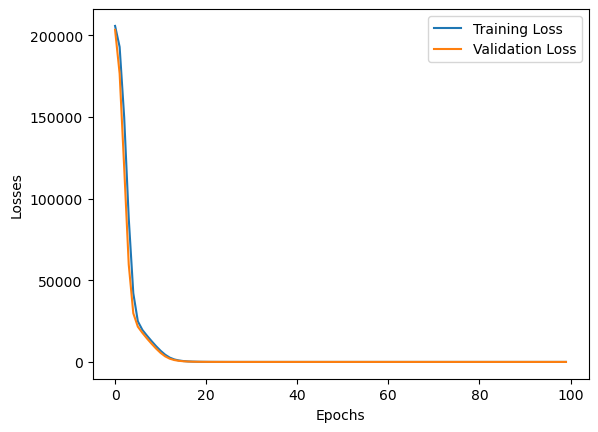

In [31]:
# ploting the graph between the losses and epoch 
import matplotlib.pyplot as plt

loss_df = pd.DataFrame({
    "Training Loss": training_loss,
    "Validation Loss": validation_loss
})

plt.plot(loss_df["Training Loss"], label = "Training Loss")
plt.plot(loss_df["Validation Loss"], label = "Validation Loss")

plt.xlabel("Epochs")
plt.ylabel("Losses")

plt.legend()

In [32]:
# loading the best model weights
model.load_state_dict(torch.load("best_model_weights.pt"))

<All keys matched successfully>

In [72]:
# evaluation on the testing data
model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor)
    test_preds = model(X_test_tensor)

    train_mse_loss = criterion(train_preds, y_train_tensor)
    ann_mse = criterion(test_preds, y_test_tensor)

print("Training MSE:", train_mse_loss.item())
print("Testing MSE:", ann_mse.item())

Training MSE: 20.558441162109375
Testing MSE: 19.013479232788086


In [71]:
#evaluating on the basis of r2 score
from sklearn.metrics import r2_score
ann_r2 = r2_score(y_test,test_preds)
print(f"r2_score : {r2}")

r2_score : 0.9335527904853983


In [37]:
#comparing the predicted and actual values
compare_df = pd.DataFrame({
    "actual_value": y_test,
    "predicted_value": test_preds.ravel()
})
compare_df

,actual_value,predicted_value
2513,433.27,435.504120
9411,438.16,436.692780
8745,458.42,461.748993
9085,480.82,476.593414
4950,441.41,435.666595
...,...,...
7204,456.70,451.364960
1599,438.04,431.583832
5697,467.80,468.061676
350,437.14,430.958984


# Linear Regression with Regularization

In [45]:
from sklearn.linear_model import LinearRegression,LassoCV,RidgeCV
from sklearn.metrics import mean_squared_error

In [66]:
#simple linear regressor
linearReg_model = LinearRegression()
linearReg_model.fit(X_train,y_train) # training 

y_pred = linearReg_model.predict(X_test)
linearReg_r2 = r2_score(y_test,y_pred)
linearReg_mse = mean_squared_error(y_test,y_pred)
print(f"r2 score : {linearReg_r2}")
print(f"mse : {linearReg_mse}")

r2 score : 0.9314747936670361
mse : 19.60808532568382


In [68]:
# Linear regrresor with lasso regularization
a = [1,2,3,0.1,0.01,0.001,0.5,0.05]
lasso_model = LassoCV(
    cv = 5,
    random_state = 42,
    alphas= a,
    max_iter=1000,
)
lasso_model.fit(X_train_scaled,y_train)
y_pred = lasso_model.predict(X_test_scaled)
lasso_r2 = r2_score(y_test,y_pred)
lasso_mse = mean_squared_error(y_test,y_pred)
print("the best alpha is ",lasso_model.alpha_)
print(f"r2 score : {lasso_r2}")
print(f"mse : {lasso_mse}")

the best alpha is  0.001
r2 score : 0.931474382779437
mse : 19.608202898757067


In [67]:
# Linear regressor with rigde regularization
a = [1,2,3,4,5,6,7,8,9,10,0.1,0.01]
ridge_model = RidgeCV(
    cv = 5,
    alphas= a,
)
ridge_model.fit(X_train_scaled,y_train)
y_pred = ridge_model.predict(X_test_scaled)
ridge_r2 = r2_score(y_test,y_pred)
ridge_mse = mean_squared_error(y_test,y_pred)
print("the best alpha is ",ridge_model.alpha_)
print(f"r2 score : {ridge_r2}")
print(f"mse : {ridge_mse}")

the best alpha is  0.1
r2 score : 0.931474782397543
mse : 19.608088550383066


# support vector machine

In [63]:
from sklearn.svm import SVR

In [70]:
svr_model = SVR()
#training
svr_model.fit(X_train_scaled,y_train)
# evaluation
y_pred = svr_model.predict(X_test_scaled)
svr_r2 = r2_score(y_test,y_pred)
svr_mse = mean_squared_error(y_test,y_pred)
print(f"r2 score : {svr_r2}")
print(f"mse : {svr_mse}")

r2 score : 0.943254533099243
mse : 16.23738207265436


# comparing the scores of all model

In [74]:
r2_scores = [ann_r2,linearReg_r2,lasso_r2,ridge_r2,svr_r2]
mse_losses = [ann_mse.item(),linearReg_mse,lasso_mse,ridge_mse,svr_mse]
indexs = ["ANN","Linear Reg","Lasso","Ridge","SVR"]
model_scores_df = pd.DataFrame({
    "r2_score" : r2_scores,
    "MSE" : mse_losses
},index=indexs)
model_scores_df

,r2_score,MSE
ANN,0.933553,19.013479
Linear Reg,0.931475,19.608085
Lasso,0.931474,19.608203
Ridge,0.931475,19.608089
SVR,0.943255,16.237382
